In [1]:
import torch
import torch.nn.functional as F

batch_size = 10
seq_len = 1000
max_id = 10
id_embed_dim = 8

In [2]:
def generate_embedding_vectors(n_vectors=100, dim=8, lr=0.01, n_iterations=10000):
    # Initialize random vectors
    vectors = torch.randn(n_vectors, dim, requires_grad=True)
    optimizer = torch.optim.Adam([vectors], lr=lr)
    
    best_loss = float('inf')
    best_vectors = None
    
    for iteration in range(n_iterations):
        optimizer.zero_grad()
        
        # Normalize vectors
        normalized_vectors = F.normalize(vectors, dim=1)
        
        # Compute all pairwise dot products
        dot_products = torch.mm(normalized_vectors, normalized_vectors.t())
        
        # Mask out diagonal (self dot products)
        mask = ~torch.eye(n_vectors, dtype=torch.bool, device=vectors.device)
        off_diagonal_dots = dot_products[mask]
        
        # Loss: minimize maximum absolute dot product
        # We use a smooth approximation of max using log-sum-exp
        abs_dots = torch.abs(off_diagonal_dots)
        loss = torch.logsumexp(abs_dots * 10, dim=0) / 10  # Temperature=10
        
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_vectors = normalized_vectors.detach().clone()
    
    print('Max dot product:', torch.abs(torch.mm(best_vectors, best_vectors.t())[mask]).max().item())
    return best_vectors


id_embeddings = generate_embedding_vectors(max_id, id_embed_dim)

Max dot product: 0.22959309816360474


In [3]:
indices = torch.randint(0, max_id, (batch_size, seq_len), dtype=torch.int64)
id_tensor = id_embeddings[indices].view(batch_size, seq_len, id_embed_dim)
id_tensor.shape

torch.Size([10, 1000, 8])

# Retrieval

Initial evaluation:
Accuracy of 1: 0.9518 (484351.0/508886)
Accuracy of 0: 0.0426 (191332.0/4496114)


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Final evaluation:
Accuracy of 1: 1.0000 (508886.0/508886)
Accuracy of 0: 0.9998 (4495114.0/4496114)


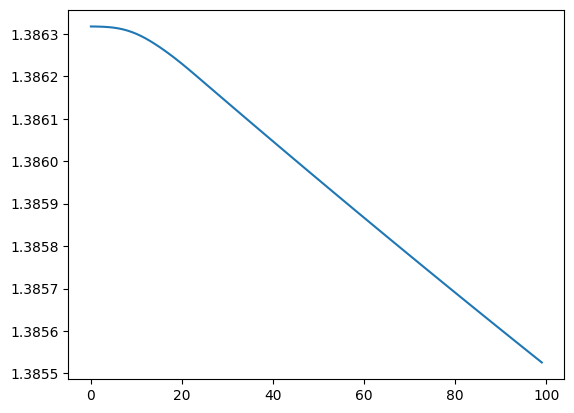

In [17]:
from torch.nn import MultiheadAttention, Linear
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

num_heads = 1
attn_model = MultiheadAttention(embed_dim=id_embed_dim, num_heads=num_heads, batch_first=True)
def get_attn_score(X_train, start, end):
    target_len = end - start
    attn_mask = torch.triu(torch.ones(target_len, X_train.shape[1]), diagonal=start+1).bool()
    # attn_mask = attn_mask.unsqueeze(0).repeat(num_heads, 1, 1)
    score = attn_model(X_train[:, start:end, :], X_train, X_train, attn_mask=attn_mask)
    return score 


def get_retrieval_target(idx, start, end):
    target_indices = torch.arange(start, end).unsqueeze(1)
    source_indices = torch.arange(0, seq_len).unsqueeze(0)
    cond1 = (target_indices > source_indices - start).unsqueeze(0).repeat(idx.shape[0], 1, 1)
    a_target = idx[:, target_indices]
    a_source = idx[:, source_indices]
    cond2 = (a_target == a_source)
    ans = (cond1 & cond2).long()
    return ans


def get_score_and_target(idx, X_train, start, end):
    """
    This score is the attention weight. The sum must be 1.
    """
    target_len = end - start
    attn_score = get_attn_score(X_train, start, end)[1]
    attn_mask = ~torch.triu(torch.ones(target_len, X_train.shape[1]), diagonal=start+1).bool()
    x = attn_score[:, attn_mask]
    # attn_score[:, ~attn_mask] is always 0 
    # print(x.shape) == [batch_size, 55]  (55 is the num of non-masked elements)
    target = get_retrieval_target(idx, start, end)
    target = target[:, attn_mask]
    # print(target.shape)  # [batch_size, 55]
    # loss = criterion(x, target.float())
    return x, target


class ExponentialMovingAverage:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.moving_avg = None
        self.history = []
    
    def update(self, value):
        if self.moving_avg is None:
            self.moving_avg = value
        else:
            self.moving_avg = self.alpha * value + (1 - self.alpha) * self.moving_avg
        self.history.append(self.moving_avg)
    
    def get_average(self):
        return self.moving_avg


def evaluation(idx, X):
    cnt_0 = 0
    cnt_1 = 0
    acc_0 = 0.0
    acc_1 = 0.0
    with torch.no_grad():
        for start in range(0, seq_len, 100):
            end = min(start + 100, seq_len)
            avg = 1.0 / seq_len
            score, target = get_score_and_target(idx, X, start, end)
            # We set the threshold to be random guess (1 / seq_len)
            x = (score > avg).long().view(-1)
            y = target.long().view(-1)
            acc_0 += ((x == y) & (y == 0)).float().sum().item()
            acc_1 += ((x == y) & (y == 1)).float().sum().item()
            cnt_0 += (y == 0).int().sum().item()
            cnt_1 += (y == 1).int().sum().item()
    print(f'Accuracy of 1: {acc_1 / cnt_1:.4f} ({acc_1}/{cnt_1})')
    print(f'Accuracy of 0: {acc_0 / cnt_0:.4f} ({acc_0}/{cnt_0})')


print('Initial evaluation:')
evaluation(indices, id_tensor)
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1000.0))
criterion = torch.nn.BCEWithLogitsLoss()
loss_ema = ExponentialMovingAverage(alpha=0.001)

n_epochs = 100
optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

for _ in tqdm(range(n_epochs)):
    start = 0
    while start < seq_len:
        ss = 5000 // (start + 1)
        assert ss > 0
        end = min(start + ss, seq_len)
        score, target = get_score_and_target(indices, id_tensor, start, end)
        score, target = score.view(-1), target.view(-1)
        # print(score.shape, target.shape)
        a = np.arange(score.shape[0])
        a = np.random.permutation(a)
        score = score[a]
        target = target[a]
        idx_0 = np.arange(score.shape[0])[target == 0]
        idx_1 = np.arange(score.shape[0])[target == 1]
        if len(idx_0) < len(idx_1):
            idx_0 = np.random.choice(idx_0, len(idx_1), replace=True)
        elif len(idx_1) < len(idx_0):
            idx_1 = np.random.choice(idx_1, len(idx_0), replace=True)
        score_0 = score[idx_0]
        score_1 = score[idx_1]
        target_0 = target[idx_0]
        target_1 = target[idx_1]
        # loss = criterion(score_1.float(), target_1.float()) 
        # loss = criterion(score_0.float(), target_0.float())
        loss = criterion(score_0.float(), target_0.float()) + criterion(score_1.float(), target_1.float())

        # loss = criterion(score.float().view(-1), target.float().view(-1))
        loss_ema.update(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # while score.shape[1] > 0:
        #     bsz = min(score.shape[1], 100)
        #     x = score[:, :bsz].float().view(-1)
        #     y = target[:, :bsz].float().view(-1)
        #     loss = criterion(x, y)
        #     score = score[:, bsz:]
        #     target = target[:, bsz:]
        #     loss_ema.update(loss.item())
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()
        start = end
    scheduler.step()

plt.plot(loss_ema.history)
print('Final evaluation:')
evaluation(indices, id_tensor)


In [18]:
# Test on OOS
test_batch_size = 3
test_seq_len = 1000
indices_test = torch.randint(0, max_id, (test_batch_size, test_seq_len), dtype=torch.int64)
id_tensor_test = id_embeddings[indices_test].view(test_batch_size, test_seq_len, id_embed_dim)
print('OOS evaluation:')
evaluation(indices_test, id_tensor_test)

OOS evaluation:
Accuracy of 1: 1.0000 (152291.0/152291)
Accuracy of 0: 0.9998 (1348909.0/1349209)


## Scratch

In [ ]:
indices[:20]

In [ ]:


start = 0
end = 25
target_len = end - start
attn_score = get_attn_score(id_tensor, start, end)[1]
attn_score[0, 10, :15]
# attn_mask = ~torch.triu(torch.ones(target_len, id_tensor.shape[1]), diagonal=start+1).bool()
# x = attn_score[:, attn_mask]
# target = get_retrieval_target(start, end)
# target = target[:, attn_mask]

prob = attn_score[0, 10, :11]
prob

